In [389]:
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import math
from lagCorrelations import getMaxCorrelations
from sklearn.metrics import mean_absolute_error
import pmdarima as pm

In [390]:
kwBR=pd.read_csv('SeriesKeywords.csv')
kwMG=pd.read_csv('SeriesKeywordsMg.csv')
kwBR=kwBR[:63]
kwMG=kwMG[:63]
conn =sqlite3.connect("indicadores.db")
brasilDf=pd.read_sql_query("select * from brazil_df",conn)
statesDf=pd.read_sql_query("select * from states_df",conn)
conn.close()

In [391]:
#Encontrando as lagcorrelations, ind é o indicador a ser usado
ind='new_week_deaths'
Corr=pd.DataFrame(getMaxCorrelations(kwBR,brasilDf,ind))
Corr=Corr.sort_values(by='MaxCorrelation',ascending=False)
Corr[:20]

,Keyword,MaxCorrelation,Lag
103,decreto lockdown,0.860029,3
49,covid,0.829267,4
123,estou com covid,0.823418,3
124,peguei covid,0.816361,1
32,oximetro,0.806206,4
33,oximetro de dedo,0.782610,3
19,teste covid,0.767422,3
34,tomar ivermectina,0.759583,2
102,lockdown covid,0.759239,5
1,sintomas do covid,0.754365,4


In [392]:
#obtendo dados apenas das semanas desejadas dos indicadores
#lag é o lag a ser explorado
lag=Corr['Lag'].iloc[0]
brasilDf=brasilDf.iloc[lag:].reset_index(drop=True)
statesDf=statesDf[statesDf['state']=='MG']
statesDf=statesDf.iloc[lag:].reset_index(drop=True)
#retirarei as ultimas semanas para considerar o lag
kwBR=kwBR[:-lag]
kwMG=kwMG[:-lag]

In [393]:
#normalizando os dados de indicador a serem usados
brasilDf['new_week_cases']=(brasilDf['new_week_cases']/brasilDf['new_week_cases'].max())*100
brasilDf['new_week_deaths']=(brasilDf['new_week_deaths']/brasilDf['new_week_deaths'].max())*100
statesDf['new_week_cases']=(statesDf['new_week_cases']/statesDf['new_week_cases'].max())*100
statesDf['new_week_deaths']=(statesDf['new_week_deaths']/statesDf['new_week_deaths'].max())*100

In [394]:
#extraindo apenas dados necessários das databases
brasilDf=brasilDf.set_index('epidemiological_week')
statesDf=statesDf.set_index('epidemiological_week')
brasilDf=brasilDf[['new_week_cases','new_week_deaths','week_last_day']]
statesDf=statesDf[['new_week_cases','new_week_deaths','week_last_day']]
kwBR=kwBR.drop('date',axis=1)
kwMG=kwMG.drop('date',axis=1)

In [395]:
X=pd.DataFrame()
X[Corr['Keyword'].iloc[0]]=kwBR[Corr['Keyword'].iloc[0]].copy()
Y=brasilDf[[ind,'week_last_day']].copy()
Y=Y.reset_index(drop=True)

In [396]:
#unindo x e y
df=X.copy()
df[ind]=Y[ind].copy()
df['date']=Y['week_last_day'].copy()
#renomeando colunas para tirar espaço e facilitar a proxima etapa
for i in df:
    df.rename({i:i.replace(' ','_')},axis=1,inplace=True)
#colocando o indice como as datas
df['date']=pd.to_datetime(df['date'])
df.set_index('date',inplace=True)
df=df.asfreq('W-Sat')

In [397]:
list(df.columns)

['decreto_lockdown', 'new_week_deaths']

# Previsão 1: Arimax com apenas a "melhor" keyword como parametro

In [398]:
from statsmodels.tsa.arima.model import ARIMA 

In [399]:
#dividindo em treino e teste
percentage=0.7
trainsize=round(percentage*len(df))
train=df[:trainsize]
test=df[trainsize:]

In [400]:
param1=pm.arima.auto_arima(train[ind],X=train.drop(ind,axis=1))
order=param1.order

In [401]:
#order foi o melhor resultado
arimax=ARIMA(endog=train[ind],freq='W-Sat',order=order,exog=train.drop(ind,axis=1)).fit()
forecast1=arimax.forecast(steps=len(test),exog=test.drop(ind,axis=1))
terr_gtrends=np.sqrt((arimax.resid**2).mean())
tmerr_gtrends=
print('ARIMA',order,' erro=',erro)

ARIMA (3, 0, 0)  erro= 3.700368733021278


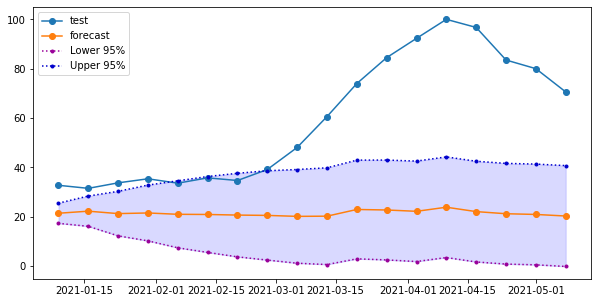

In [402]:
predict=arimax.get_forecast(steps=len(test),exog=test.drop(ind,axis=1)).summary_frame()
plt.figure(figsize=(10,5))
plt.plot(test[ind],label='test', linestyle='-', marker='o')
plt.plot(forecast1,label='forecast', linestyle='-', marker='o')
plt.plot(predict['mean_ci_lower'], color='#990099', marker='.', linestyle=':', label='Lower 95%')
plt.plot(predict['mean_ci_upper'], color='#0000cc', marker='.', linestyle=':', label='Upper 95%')
plt.fill_between(test.index,predict['mean_ci_lower'], predict['mean_ci_upper'], color = 'b', alpha = 0.15)
plt.legend()
plt.show()

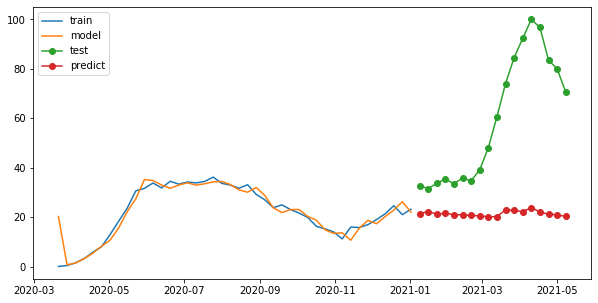

In [403]:
plt.figure(figsize=(10,5))
plt.plot(train[ind], linestyle='-',label='train')
plt.plot(arimax.predict(), linestyle='-',label='model')
plt.plot(test[ind],label='test',linestyle='-', marker='o')
plt.plot(forecast1,label='predict', linestyle='-', marker='o')
plt.legend()
plt.show()

In [404]:
predict

new_week_deaths,mean,mean_se,mean_ci_lower,mean_ci_upper
2021-01-09,21.428590,2.086613,17.338902,25.518277
2021-01-16,22.269501,3.129373,16.136043,28.402959
2021-01-23,21.285204,4.603813,12.261896,30.308512
2021-01-30,21.545533,5.768163,10.240142,32.850924
2021-02-06,21.001126,6.926232,7.425962,34.576290
2021-02-13,20.934910,7.848469,5.552194,36.317626
2021-02-20,20.689860,8.638657,3.758403,37.621317
2021-02-27,20.555066,9.235298,2.454214,38.655918
2021-03-06,20.166450,9.689113,1.176137,39.156763
2021-03-13,20.244631,10.000150,0.644698,39.844564


In [405]:
#erro da previsão
from sklearn.metrics import mean_squared_error
err_gtrends=mean_squared_error(forecast1,test[ind],squared=False)
merr_gtrends= mean_absolute_error(forecast1,test[ind])

# Teste 1: Arima apenas com o indicador

In [406]:
param2=pm.arima.auto_arima(train[ind])
order=param2.order

In [407]:
#order foi o melhor resultado
arima=ARIMA(train[ind],freq='W-Sat',order=order).fit()
forecast2=arima.forecast(steps=len(test))
terr_nogtrends=np.sqrt((arima.resid**2).mean())
tmerr_nogtrends=(np.abs(arima.resid)).mean()
print('ARIMA',order,' erro=',terr_nogtrends, tmerr_nogtrends)

ARIMA (3, 0, 0)  erro= 3.741059927459121 2.032581215404774


In [408]:
arima.pvalues

const     1.882781e-07
ar.L1     2.321967e-09
ar.L2     3.478240e-01
ar.L3     1.026381e-02
sigma2    3.241871e-05
dtype: float64

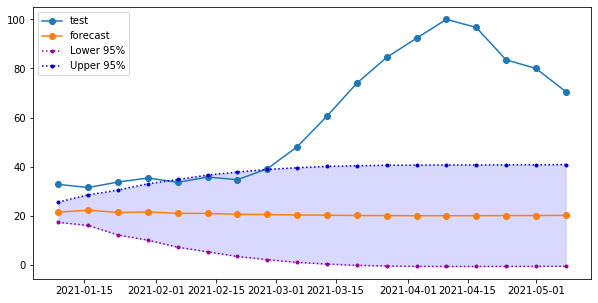

In [409]:
predict=arima.get_forecast(steps=len(test)).summary_frame()
plt.figure(figsize=(10,5))
plt.plot(test[ind],label='test', linestyle='-', marker='o')
plt.plot(forecast2,label='forecast', linestyle='-', marker='o')
plt.plot(predict['mean_ci_lower'], color='#990099', marker='.', linestyle=':', label='Lower 95%')
plt.plot(predict['mean_ci_upper'], color='#0000cc', marker='.', linestyle=':', label='Upper 95%')
plt.fill_between(test.index,predict['mean_ci_lower'], predict['mean_ci_upper'], color = 'b', alpha = 0.15)
plt.legend()
plt.show()

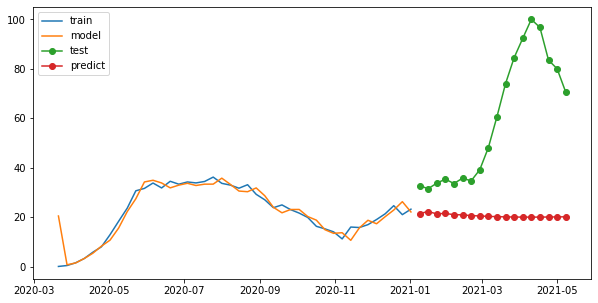

In [410]:
plt.figure(figsize=(10,5))
plt.plot(train[ind], linestyle='-',label='train')
plt.plot(arima.predict(), linestyle='-',label='model')
plt.plot(test[ind],label='test',linestyle='-', marker='o')
plt.plot(forecast2,label='predict', linestyle='-', marker='o')
plt.legend()
plt.show()

In [411]:
predict

new_week_deaths,mean,mean_se,mean_ci_lower,mean_ci_upper
2021-01-09,21.474596,2.113857,17.331513,25.617679
2021-01-16,22.289046,3.178679,16.058950,28.519142
2021-01-23,21.341645,4.674444,12.179903,30.503388
2021-01-30,21.549552,5.860992,10.062220,33.036884
2021-02-06,20.991712,7.036055,7.201298,34.782127
2021-02-13,20.963725,7.973459,5.336032,36.591418
2021-02-20,20.616490,8.773517,3.420713,37.812266
2021-02-27,20.524761,9.377167,2.145852,38.903669
2021-03-06,20.312161,9.833999,1.037878,39.586445
2021-03-13,20.232281,10.145817,0.346845,40.117717


In [412]:
#erro da previsão
err_nogtrends=mean_squared_error(forecast2,test[ind],squared=False)
merr_nogtrends= mean_absolute_error(forecast2,test[ind])

In [413]:
#comparando os erros das previsões
print("Erro da previsão sem gtrends: ",err_nogtrends,"\nErro da previsão com gtrends: ",err_gtrends)

Erro da previsão sem gtrends:  46.30276271522682 
Erro da previsão com gtrends:  45.019503835852284


# Sobre a previsão 1
Temos uma previsão, mas será que os dados google trends realmente a auxiliaram?

O que pode-se observar, é que realmente auxiliaram a previsão de casos, mas não a de mortes.

# Previsão 2 - Usando todas as keywords com alta correlação até um determinado lag

In [414]:
kwBR=pd.read_csv('SeriesKeywords.csv')
kwMG=pd.read_csv('SeriesKeywordsMg.csv')
kwBR=kwBR[:63]
kwMG=kwMG[:63]
conn =sqlite3.connect("indicadores.db")
brasilDf=pd.read_sql_query("select * from brazil_df",conn)
statesDf=pd.read_sql_query("select * from states_df",conn)
conn.close()

In [415]:
#obtendo dados apenas das semanas desejadas dos indicadores
#lag é o max lag a ser explorado
lag=4
brasilDf=brasilDf.iloc[lag:].reset_index(drop=True)
statesDf=statesDf[statesDf['state']=='MG']
statesDf=statesDf.iloc[lag:].reset_index(drop=True)

In [416]:
#normalizando os dados de indicador a serem usados
brasilDf['new_week_cases']=(brasilDf['new_week_cases']/brasilDf['new_week_cases'].max())*100
brasilDf['new_week_deaths']=(brasilDf['new_week_deaths']/brasilDf['new_week_deaths'].max())*100
statesDf['new_week_cases']=(statesDf['new_week_cases']/statesDf['new_week_cases'].max())*100
statesDf['new_week_deaths']=(statesDf['new_week_deaths']/statesDf['new_week_deaths'].max())*100

In [417]:
#extraindo apenas dados necessários das databases
brasilDf=brasilDf.set_index('epidemiological_week')
statesDf=statesDf.set_index('epidemiological_week')
brasilDf=brasilDf[['new_week_cases','new_week_deaths','week_last_day']]
statesDf=statesDf[['new_week_cases','new_week_deaths','week_last_day']]
kwBR=kwBR.drop('date',axis=1)
kwMG=kwMG.drop('date',axis=1)

In [418]:
X=pd.DataFrame()
for i in range(len(Corr)):
    if Corr['Lag'].iloc[i]<=lag and np.abs(Corr['MaxCorrelation'].iloc[i])>=0.7:
        try:
            X[Corr['Keyword'].iloc[i]]=kwBR[lag-Corr['Lag'].iloc[i]:-Corr['Lag'].iloc[i]].reset_index()[Corr['Keyword'].iloc[i]].copy()
        except:
            print(i,Corr['Keyword'].iloc[i])
Y=brasilDf[[ind,'week_last_day']].copy()
Y=Y.reset_index(drop=True)

In [419]:
#unindo x e y
df=X.copy()
df[ind]=Y[ind].copy()
df['date']=Y['week_last_day'].copy()
#renomeando colunas para tirar espaço e facilitar a proxima etapa
for i in df:
    df.rename({i:i.replace(' ','_')},axis=1,inplace=True)
#colocando o indice como as datas
df['date']=pd.to_datetime(df['date'])
df.set_index('date',inplace=True)
df=df.asfreq('W-Sat')

In [420]:
list(df.columns)

['decreto_lockdown',
 'covid',
 'estou_com_covid',
 'peguei_covid',
 'oximetro',
 'oximetro_de_dedo',
 'teste_covid',
 'tomar_ivermectina',
 'sintomas_do_covid',
 'reagente_igg',
 'taxa_de_ocupação_de_leitos',
 'teste_rápido_covid',
 'exame_covid',
 'new_week_deaths']

In [421]:
#dividindo em treino e teste
trainsize=round(percentage*len(df))
train=df[:trainsize]
test=df[trainsize:]

In [422]:
param3=pm.arima.auto_arima(train[ind],X=train.drop(ind,axis=1))
order=param3.order

In [423]:
#order foi o melhor resultado
arimax=ARIMA(endog=train[ind],freq='W-Sat',order=order,exog=train.drop(ind,axis=1)).fit()
forecast3=arimax.forecast(steps=len(test),exog=test.drop(ind,axis=1))
terr_keywords=np.sqrt((arimax.resid**2).mean())
tmerr_keywords=(np.abs(arimax.resid)).mean()
print('ARIMA',order,' erro=',erro,merro)

ARIMA (0, 0, 1)  erro= 3.700368733021278 1.5279897354340473


C:\Users\msart\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [424]:
arimax.pvalues

const                         9.621550e-01
decreto_lockdown              1.367416e-02
covid                         3.873242e-02
estou_com_covid               4.612893e-01
peguei_covid                  6.666884e-01
oximetro                      6.932923e-01
oximetro_de_dedo              2.536582e-01
teste_covid                   4.608025e-01
tomar_ivermectina             4.166896e-02
sintomas_do_covid             1.230749e-01
reagente_igg                  1.594323e-02
taxa_de_ocupação_de_leitos    2.749509e-01
teste_rápido_covid            3.580257e-03
exame_covid                   5.958833e-01
ma.L1                         7.714935e-11
sigma2                        9.693588e-03
dtype: float64

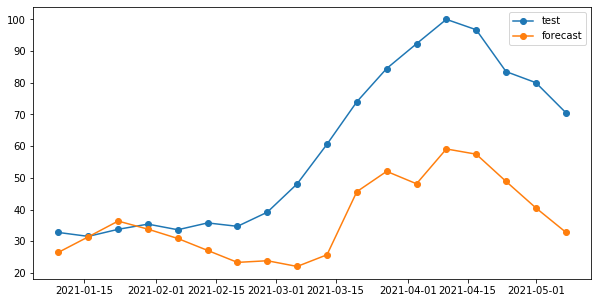

In [425]:
predict=arimax.get_forecast(steps=len(test),exog=test.drop(ind,axis=1)).summary_frame()
plt.figure(figsize=(10,5))
plt.plot(test[ind],label='test', linestyle='-', marker='o')
plt.plot(forecast3,label='forecast', linestyle='-', marker='o')
#plt.plot(predict['mean_ci_lower'], color='#990099', marker='.', linestyle=':', label='Lower 95%')
#plt.plot(predict['mean_ci_upper'], color='#0000cc', marker='.', linestyle=':', label='Upper 95%')
#plt.fill_between(test.index,predict['mean_ci_lower'], predict['mean_ci_upper'], color = 'b', alpha = 0.15)
plt.legend()
plt.show()

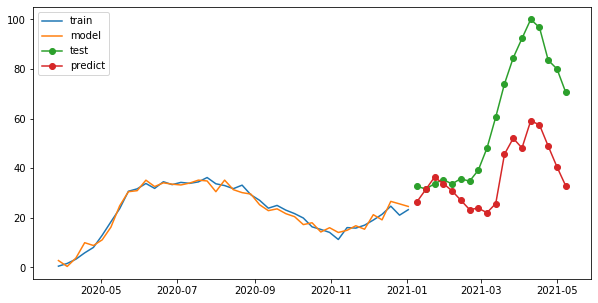

In [426]:
plt.figure(figsize=(10,5))
plt.plot(train[ind], linestyle='-',label='train')
plt.plot(arimax.predict(), linestyle='-',label='model')
plt.plot(test[ind],label='test',linestyle='-', marker='o')
plt.plot(forecast3,label='predict', linestyle='-', marker='o')
plt.legend()
plt.show()

In [427]:
err_keywords=mean_squared_error(forecast3,test[ind],squared=False)
merr_keywords= mean_absolute_error(forecast3,test[ind])
print(err_keywords,merr_keywords)

27.487833175459173 22.595451161488267


# Previsão 3: Usando Arimax com as keywords Gtrends e new_week_cases com o lag que garante maior correlação

In [428]:
kwBR=pd.read_csv('SeriesKeywords.csv')
kwMG=pd.read_csv('SeriesKeywordsMg.csv')
kwBR=kwBR[:63]
kwMG=kwMG[:63]
conn =sqlite3.connect("indicadores.db")
brasilDf=pd.read_sql_query("select * from brazil_df",conn)
brasilDf2=pd.read_sql_query("select * from brazil_df",conn)
statesDf=pd.read_sql_query("select * from states_df",conn)
conn.close()

In [429]:
#obtendo dados apenas das semanas desejadas dos indicadores
#lag é o max lag a ser explorado
lag=4
brasilDf=brasilDf.iloc[lag:].reset_index(drop=True)
statesDf=statesDf[statesDf['state']=='MG']
statesDf=statesDf.iloc[lag:].reset_index(drop=True)

In [430]:
#normalizando os dados de indicador a serem usados
brasilDf['new_week_cases']=(brasilDf['new_week_cases']/brasilDf['new_week_cases'].max())*100
brasilDf2['new_week_cases']=(brasilDf2['new_week_cases']/brasilDf2['new_week_cases'].max())*100
brasilDf['new_week_deaths']=(brasilDf['new_week_deaths']/brasilDf['new_week_deaths'].max())*100
statesDf['new_week_cases']=(statesDf['new_week_cases']/statesDf['new_week_cases'].max())*100
statesDf['new_week_deaths']=(statesDf['new_week_deaths']/statesDf['new_week_deaths'].max())*100

In [431]:
#extraindo apenas dados necessários das databases
brasilDf=brasilDf.set_index('epidemiological_week')
statesDf=statesDf.set_index('epidemiological_week')
brasilDf=brasilDf[['new_week_cases','new_week_deaths','week_last_day']]
statesDf=statesDf[['new_week_cases','new_week_deaths','week_last_day']]
kwBR=kwBR.drop('date',axis=1)
kwMG=kwMG.drop('date',axis=1)

In [432]:
X=pd.DataFrame()
for i in range(len(Corr)):
    if Corr['Lag'].iloc[i]<=lag and np.abs(Corr['MaxCorrelation'].iloc[i])>=0.7:
        try:
            X[Corr['Keyword'].iloc[i]]=kwBR[lag-Corr['Lag'].iloc[i]:-Corr['Lag'].iloc[i]].reset_index()[Corr['Keyword'].iloc[i]].copy()
        except:
            print(i,Corr['Keyword'].iloc[i])
Y=brasilDf[[ind,'week_last_day']].copy()
Y=Y.reset_index(drop=True)

In [433]:
#achando o lag otimo para new_week_cases
k=pd.DataFrame()
k[ind]=Y[ind]
maxcor=0
for i in range(0,5):
    k['new_week_cases']=brasilDf2[i:-(4-i)].reset_index()['new_week_cases']
    cor=k.corr(method='spearman')['new_week_cases'].loc['new_week_deaths']
    if(cor>maxcor):
        maxcor=cor
        newcaseslag=i
print(maxcor,newcaseslag)

0.8036820572764465 3


In [434]:
#unindo x e y
df=X.copy()
df[ind]=Y[ind].copy()
df['date']=Y['week_last_day'].copy()
#renomeando colunas para tirar espaço e facilitar a proxima etapa
for i in df:
    df.rename({i:i.replace(' ','_')},axis=1,inplace=True)
df['new_week_cases']=brasilDf2[newcaseslag:-(4-newcaseslag)].reset_index()['new_week_cases']
#colocando o indice como as datas
df['date']=pd.to_datetime(df['date'])
df.set_index('date',inplace=True)
df=df.asfreq('W-Sat')

In [435]:
list(df.columns)

['decreto_lockdown',
 'covid',
 'estou_com_covid',
 'peguei_covid',
 'oximetro',
 'oximetro_de_dedo',
 'teste_covid',
 'tomar_ivermectina',
 'sintomas_do_covid',
 'reagente_igg',
 'taxa_de_ocupação_de_leitos',
 'teste_rápido_covid',
 'exame_covid',
 'new_week_deaths',
 'new_week_cases']

In [436]:
#dividindo em treino e teste
trainsize=round(percentage*len(df))
train=df[:trainsize]
test=df[trainsize:]

In [437]:
param4=pm.arima.auto_arima(train[ind],X=train.drop(ind,axis=1))
order=param4.order

In [438]:
#order foi o melhor resultado
arimax=ARIMA(endog=train[ind],freq='W-Sat',order=order,exog=train.drop(ind,axis=1)).fit()
forecast4=arimax.forecast(steps=len(test),exog=test.drop(ind,axis=1))
terr_allparameters=np.sqrt((arimax.resid**2).mean())
tmerr_allparameters=(np.abs(arimax.resid)).mean()
print('ARIMA',order,' erro=',erro)

ARIMA (0, 0, 1)  erro= 3.700368733021278


C:\Users\msart\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


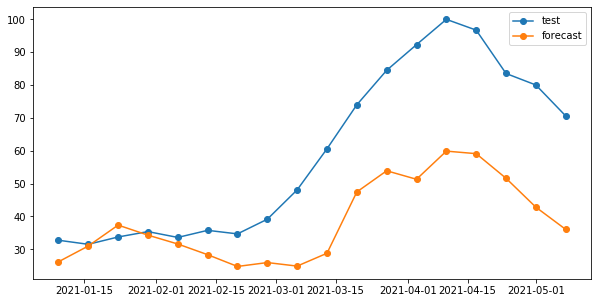

In [439]:
predict=arimax.get_forecast(steps=len(test),exog=test.drop(ind,axis=1)).summary_frame()
plt.figure(figsize=(10,5))
plt.plot(test[ind],label='test', linestyle='-', marker='o')
plt.plot(forecast4,label='forecast', linestyle='-', marker='o')
#plt.plot(predict['mean_ci_lower'], color='#990099', marker='.', linestyle=':', label='Lower 95%')
#plt.plot(predict['mean_ci_upper'], color='#0000cc', marker='.', linestyle=':', label='Upper 95%')
#plt.fill_between(test.index,predict['mean_ci_lower'], predict['mean_ci_upper'], color = 'b', alpha = 0.15)
plt.legend()
plt.show()

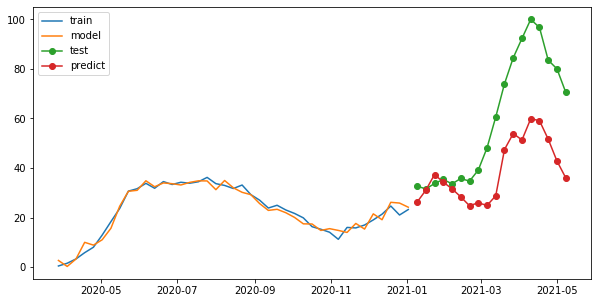

In [440]:
plt.figure(figsize=(10,5))
plt.plot(train[ind], linestyle='-',label='train')
plt.plot(arimax.predict(), linestyle='-',label='model')
plt.plot(test[ind],label='test',linestyle='-', marker='o')
plt.plot(forecast4,label='predict', linestyle='-', marker='o')
plt.legend()
plt.show()

In [441]:
predict

new_week_deaths,mean,mean_se,mean_ci_lower,mean_ci_upper
2021-01-09,26.196363,1.792431,22.683263,29.709463
2021-01-16,31.005298,2.284371,26.528014,35.482582
2021-01-23,37.366339,2.284371,32.889055,41.843623
2021-01-30,34.310248,2.284371,29.832964,38.787532
2021-02-06,31.612953,2.284371,27.135669,36.090237
2021-02-13,28.359019,2.284371,23.881735,32.836303
2021-02-20,24.781831,2.284371,20.304547,29.259115
2021-02-27,25.961120,2.284371,21.483836,30.438404
2021-03-06,24.889011,2.284371,20.411727,29.366295
2021-03-13,28.796682,2.284371,24.319398,33.273966


In [442]:
err_allparameters=mean_squared_error(forecast4,test[ind],squared=False)
merr_allparameters= mean_absolute_error(forecast4,test[ind])

# Teste 2- Arimax apenas com o new_week_cases com lag

In [443]:
param5=pm.arima.auto_arima(train[ind],X=train['new_week_cases'].values.reshape(-1,1))
order=param5.order

In [444]:
#order foi o melhor resultado
arimax=ARIMA(endog=train[ind],freq='W-Sat',order=order,exog=train['new_week_cases']).fit()
forecast5=arimax.forecast(steps=len(test),exog=test['new_week_cases'])
terr_nwcases=np.sqrt((arimax.resid**2).mean())
tmerr_nwcases=(np.abs(arimax.resid)).mean()
print('ARIMA',order,' erro=',erro)

ARIMA (1, 1, 2)  erro= 3.700368733021278


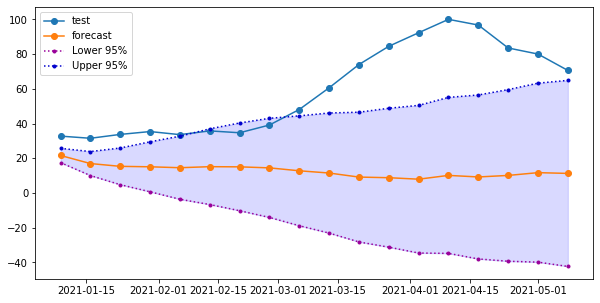

In [445]:
predict=arimax.get_forecast(steps=len(test),exog=test['new_week_cases']).summary_frame()
plt.figure(figsize=(10,5))
plt.plot(test[ind],label='test', linestyle='-', marker='o')
plt.plot(forecast5,label='forecast', linestyle='-', marker='o')
plt.plot(predict['mean_ci_lower'], color='#990099', marker='.', linestyle=':', label='Lower 95%')
plt.plot(predict['mean_ci_upper'], color='#0000cc', marker='.', linestyle=':', label='Upper 95%')
plt.fill_between(test.index,predict['mean_ci_lower'], predict['mean_ci_upper'], color = 'b', alpha = 0.15)
plt.legend()
plt.show()

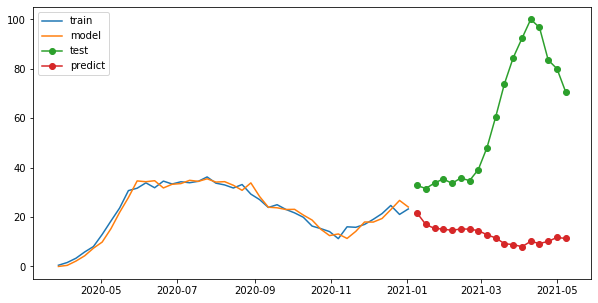

In [446]:
plt.figure(figsize=(10,5))
plt.plot(train[ind], linestyle='-',label='train')
plt.plot(arimax.predict(), linestyle='-',label='model')
plt.plot(test[ind],label='test',linestyle='-', marker='o')
plt.plot(forecast5,label='predict', linestyle='-', marker='o')
plt.legend()
plt.show()

In [447]:
predict

new_week_deaths,mean,mean_se,mean_ci_lower,mean_ci_upper
2021-01-09,21.619565,2.097417,17.508702,25.730427
2021-01-16,16.967029,3.525606,10.056969,23.877090
2021-01-23,15.362031,5.389301,4.799196,25.924867
2021-01-30,15.098524,7.343430,0.705666,29.491382
2021-02-06,14.566659,9.270139,-3.602479,32.735797
2021-02-13,15.168845,11.124251,-6.634287,36.971976
2021-02-20,15.069336,12.889188,-10.193010,40.331681
2021-02-27,14.481044,14.561367,-14.058710,43.020799
2021-03-06,12.802709,16.143397,-18.837768,44.443185
2021-03-13,11.507817,17.640754,-23.067425,46.083058


In [448]:
err_nwcases=mean_squared_error(forecast5,test[ind],squared=False)
merr_nwcases= mean_absolute_error(forecast5,test[ind])
print('Erro todos parametros: ',err_allparameters,"Erro apenas new_week_cases: ",err_nwcases)

Erro todos parametros:  25.68463993478218 Erro apenas new_week_cases:  54.188036891134665


# Observações

Como pode ser visto, ao retirar as keywords do google trends o resultado da previsão se torna bastante pior, indicando que não são só os novos casos contribuindo para a previsão

# Teste regressão linear

In [449]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

In [450]:
X=df.drop(['new_week_cases','new_week_deaths'],axis=1)
y=df['new_week_deaths']

In [451]:
#dividindo treino e teste
trainsize=round(percentage*len(X))
Xtrain=X[:trainsize]
Xtest=X[trainsize:]
ytrain=y[:trainsize]
ytest=y[trainsize:]

In [452]:
reg = LinearRegression()
#.fit(Xtrain, ytrain)

In [453]:
scores = cross_val_score(reg, Xtrain, ytrain, cv=5,scoring='neg_root_mean_squared_error')
MAEscores= cross_val_score(reg, Xtrain, ytrain, cv=5,scoring='neg_mean_absolute_error') 

In [454]:
(scores.mean(), scores.std())

(-8.061084847574866, 3.917056748564935)

In [455]:
(MAEscores.mean(), MAEscores.std())

(-6.1442512475242745, 3.125005536100124)

In [456]:
terror=np.abs(scores.mean())
tmerror=np.abs(MAEscores.mean())

In [457]:
reg=reg.fit(Xtrain, ytrain)

In [458]:
reg.coef_

array([ 0.20186844,  0.12184031, -0.01643096, -0.04805647,  0.00210853,
        0.03396085,  0.09538521, -0.12715588,  0.11240651,  0.09141541,
        0.07317324,  0.20176813, -0.01818853])

In [459]:
yhat=reg.predict(Xtest)

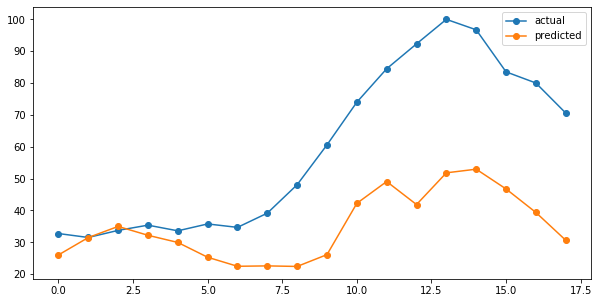

In [460]:
plt.figure(figsize=(10,5))
plt.plot(ytest.values,label='actual', linestyle='-', marker='o')
plt.plot(yhat,label='predicted', linestyle='-', marker='o')
plt.legend()
plt.show()

In [461]:
ypz=reg.predict(X.values)

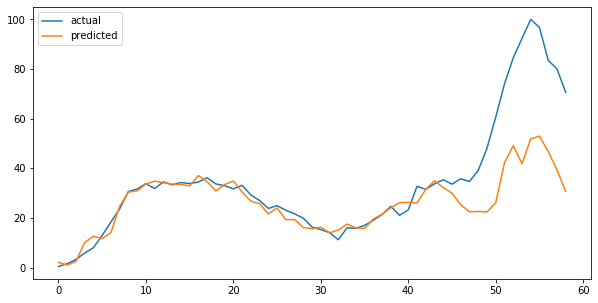

In [462]:
plt.figure(figsize=(10,5))
plt.plot(y.values,label='actual')
plt.plot(ypz,label='predicted')
plt.legend()
plt.show()

In [463]:
error = mean_squared_error(yhat,ytest,squared=False)
merror= mean_absolute_error(yhat,ytest)

# Teste Regressão polinomial

(houve muito overfitting)

In [464]:
from sklearn.preprocessing import PolynomialFeatures

In [465]:
poly = PolynomialFeatures(degree=2)
X_ = poly.fit_transform(X)
X_train=X_[:trainsize]
X_test=X_[trainsize:]

In [466]:
clf = LinearRegression()
clf.fit(X_train, ytrain)
y_hat=clf.predict(X_test)
y_pz=clf.predict(X_)

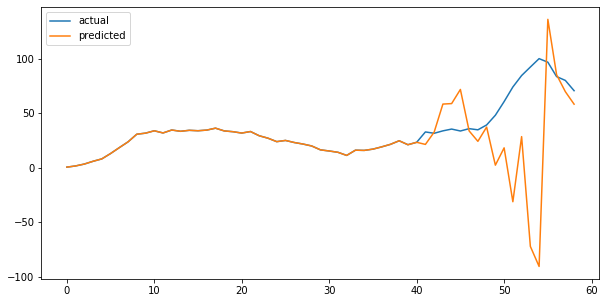

In [467]:
plt.figure(figsize=(10,5))
plt.plot(y.values,label='actual', linestyle='-')
plt.plot(y_pz,label='predicted', linestyle='-')
plt.legend()
plt.show()

# Comparando alguns forecasts

In [468]:
print("RMSE treino\nErro regressão linear: ",terror,"\nErro da previsão sem gtrends: ",terr_nogtrends,"\nErro da previsão com gtrends: ",terr_gtrends,'\nErro todos parametros: ',terr_allparameters,"\nErro apenas new_week_cases: ",terr_nwcases,'\nErro todas keywords: ',terr_keywords)

NameError: name 'terr_gtrends' is not defined

In [ ]:
print("MAE treino\nErro regressão linear: ",tmerror,"\nerro da previsão sem gtrends: ",tmerr_nogtrends,"\nErro da previsão com gtrends: ",tmerr_gtrends,'\nErro todos parametros: ',tmerr_allparameters,"\nErro apenas new_week_cases: ",tmerr_nwcases,'\nErro todas keywords: ',tmerr_keywords)

In [ ]:
print("RMSE teste\nErro regressão linear: ",error,"\nErro da previsão sem gtrends: ",err_nogtrends,"\nErro da previsão com gtrends: ",err_gtrends,'\nErro todos parametros: ',err_allparameters,"\nErro apenas new_week_cases: ",err_nwcases,'\nErro todas keywords: ',err_keywords)

In [ ]:
print("MAE teste\nErro regressão linear: ",merror,"\nerro da previsão sem gtrends: ",merr_nogtrends,"\nErro da previsão com gtrends: ",merr_gtrends,'\nErro todos parametros: ',merr_allparameters,"\nErro apenas new_week_cases: ",merr_nwcases,'\nErro todas keywords: ',merr_keywords)

In [ ]:
#Gráfico com forecasts
ytest=ytest.reset_index()
ytest['poly']=y_hat
ytest['reg']=yhat
ytest.set_index('date',inplace=True)
plt.figure(figsize=(10,5))
plt.ylim(0,105)
plt.plot(ytest['new_week_deaths'],label='new_week_deaths', linestyle='-',marker='o')
plt.plot(ytest['reg'],label='Linear regression', linestyle='-',marker='o')
plt.plot(forecast2,label='ARIMA', linestyle='-',marker='o')
#plt.plot(forecast4,label='ARIMA(keywords+new_week_cases)', linestyle='-',marker='o')
plt.plot(forecast3,label='ARIMAX', linestyle='-',marker='o')
plt.xlabel('date')
plt.ylabel('% in relation to peak value')
plt.legend()
plt.grid()
plt.savefig('graficos\\RegressoesMortes.png')
plt.show()

# Para new week cases

In [ ]:
#Encontrando as lagcorrelations, ind é o indicador a ser usado
ind='new_week_cases'
Corr=pd.DataFrame(getMaxCorrelations(kwBR,brasilDf,ind))
Corr=Corr.sort_values(by='MaxCorrelation',ascending=False)
Corr[:20]

In [ ]:
kwBR=pd.read_csv('SeriesKeywords.csv')
kwMG=pd.read_csv('SeriesKeywordsMg.csv')
kwBR=kwBR[:63]
kwMG=kwMG[:63]
conn =sqlite3.connect("indicadores.db")
brasilDf=pd.read_sql_query("select * from brazil_df",conn)
statesDf=pd.read_sql_query("select * from states_df",conn)
conn.close()

In [ ]:
#obtendo dados apenas das semanas desejadas dos indicadores
#lag é o max lag a ser explorado
lag=4
brasilDf=brasilDf.iloc[lag:].reset_index(drop=True)
statesDf=statesDf[statesDf['state']=='MG']
statesDf=statesDf.iloc[lag:].reset_index(drop=True)

In [ ]:
#normalizando os dados de indicador a serem usados
brasilDf['new_week_cases']=(brasilDf['new_week_cases']/brasilDf['new_week_cases'].max())*100
brasilDf['new_week_deaths']=(brasilDf['new_week_deaths']/brasilDf['new_week_deaths'].max())*100
statesDf['new_week_cases']=(statesDf['new_week_cases']/statesDf['new_week_cases'].max())*100
statesDf['new_week_deaths']=(statesDf['new_week_deaths']/statesDf['new_week_deaths'].max())*100

In [ ]:
#extraindo apenas dados necessários das databases
brasilDf=brasilDf.set_index('epidemiological_week')
statesDf=statesDf.set_index('epidemiological_week')
brasilDf=brasilDf[['new_week_cases','new_week_deaths','week_last_day']]
statesDf=statesDf[['new_week_cases','new_week_deaths','week_last_day']]
kwBR=kwBR.drop('date',axis=1)
kwMG=kwMG.drop('date',axis=1)

In [ ]:
X=pd.DataFrame()
for i in range(len(Corr)):
    if Corr['Lag'].iloc[i]<=lag and np.abs(Corr['MaxCorrelation'].iloc[i])>=0.7:
        try:
            X[Corr['Keyword'].iloc[i]]=kwBR[lag-Corr['Lag'].iloc[i]:-Corr['Lag'].iloc[i]].reset_index()[Corr['Keyword'].iloc[i]].copy()
        except:
            print(i,Corr['Keyword'].iloc[i])
Y=brasilDf[[ind,'week_last_day']].copy()
Y=Y.reset_index(drop=True)

In [ ]:
#unindo x e y
df=X.copy()
df[ind]=Y[ind].copy()
df['date']=Y['week_last_day'].copy()
#renomeando colunas para tirar espaço e facilitar a proxima etapa
for i in df:
    df.rename({i:i.replace(' ','_')},axis=1,inplace=True)
#colocando o indice como as datas
df['date']=pd.to_datetime(df['date'])
df.set_index('date',inplace=True)
df=df.asfreq('W-Sat')

In [ ]:
list(df.columns)

In [ ]:
#dividindo em treino e teste
trainsize=round(percentage*len(df))
train=df[:trainsize]
test=df[trainsize:]

# ARIMA

In [ ]:
param=pm.arima.auto_arima(train[ind])
order=param.order

In [ ]:
#order foi o melhor resultado
arimax=ARIMA(endog=train[ind],freq='W-Sat',order=order).fit()
forecast2=arimax.forecast(steps=len(test))
terr_nogtrends=np.sqrt((arimax.resid**2).mean())
tmerr_nogtrends=(np.abs(arimax.resid)).mean()
print('ARIMA',order,' erro=',erro,merro)

In [ ]:
predict=arimax.get_forecast(steps=len(test)).summary_frame()
plt.figure(figsize=(10,5))
plt.plot(test[ind],label='test', linestyle='-', marker='o')
plt.plot(forecast2,label='forecast', linestyle='-', marker='o')
#plt.plot(predict['mean_ci_lower'], color='#990099', marker='.', linestyle=':', label='Lower 95%')
#plt.plot(predict['mean_ci_upper'], color='#0000cc', marker='.', linestyle=':', label='Upper 95%')
#plt.fill_between(test.index,predict['mean_ci_lower'], predict['mean_ci_upper'], color = 'b', alpha = 0.15)
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(train[ind], linestyle='-',label='train')
plt.plot(arimax.predict(), linestyle='-',label='model')
plt.plot(test[ind],label='test',linestyle='-', marker='o')
plt.plot(forecast2,label='predict', linestyle='-', marker='o')
plt.legend()
plt.show()

In [ ]:
err_nogtrends=mean_squared_error(forecast2,test[ind],squared=False)
merr_nogtrends= mean_absolute_error(forecast2,test[ind])

In [ ]:
err_nogtrends,merr_nogtrends

# Arimax

In [ ]:
param3=pm.arima.auto_arima(train[ind],X=train.drop(ind,axis=1))
order=param3.order

In [ ]:
#order foi o melhor resultado
arimax=ARIMA(endog=train[ind],freq='W-Sat',order=order,exog=train.drop(ind,axis=1)).fit()
forecast3=arimax.forecast(steps=len(test),exog=test.drop(ind,axis=1))
terr_keywords=np.sqrt((arimax.resid**2).mean())
tmerr_keywords=(np.abs(arimax.resid)).mean()
print('ARIMA',order,' erro=',terr_keywords,tmerr_keywords)

In [ ]:
predict=arimax.get_forecast(steps=len(test),exog=test.drop(ind,axis=1)).summary_frame()
plt.figure(figsize=(10,5))
plt.plot(test[ind],label='test', linestyle='-', marker='o')
plt.plot(forecast3,label='forecast', linestyle='-', marker='o')
#plt.plot(predict['mean_ci_lower'], color='#990099', marker='.', linestyle=':', label='Lower 95%')
#plt.plot(predict['mean_ci_upper'], color='#0000cc', marker='.', linestyle=':', label='Upper 95%')
#plt.fill_between(test.index,predict['mean_ci_lower'], predict['mean_ci_upper'], color = 'b', alpha = 0.15)
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(train[ind], linestyle='-',label='train')
plt.plot(arimax.predict(), linestyle='-',label='model')
plt.plot(test[ind],label='test',linestyle='-', marker='o')
plt.plot(forecast3,label='predict', linestyle='-', marker='o')
plt.legend()
plt.show()

In [ ]:
err_keywords=mean_squared_error(forecast3,test[ind],squared=False)
merr_keywords= mean_absolute_error(forecast3,test[ind])

In [ ]:
err_keywords, merr_keywords

# Regressão linear new_week_cases

In [ ]:
X=df.drop(['new_week_cases'],axis=1)
y=df['new_week_cases']

In [ ]:
#dividindo treino e teste
trainsize=round(percentage*len(X))
Xtrain=X[:trainsize]
Xtest=X[trainsize:]
ytrain=y[:trainsize]
ytest=y[trainsize:]
reg = LinearRegression()
scores = cross_val_score(reg, Xtrain, ytrain, cv=5,scoring='neg_root_mean_squared_error')
MAEscores= cross_val_score(reg, Xtrain, ytrain, cv=5,scoring='neg_mean_absolute_error') 
reg=reg.fit(Xtrain, ytrain)
yhat=reg.predict(Xtest)

In [ ]:
(scores.mean(), scores.std())

In [ ]:
(MAEscores.mean(), MAEscores.std())

In [ ]:
terror=np.abs(scores.mean())
tmerror=np.abs(MAEscores.mean())

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(ytest.values,label='actual', linestyle='-', marker='o')
plt.plot(yhat,label='predicted', linestyle='-', marker='o')
plt.legend()
plt.show()

In [ ]:
ypz=reg.predict(X.values)

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(y.values,label='actual')
plt.plot(ypz,label='predicted')
plt.legend()
plt.show()

In [ ]:
error = mean_squared_error(yhat,ytest,squared=False)
merror = mean_absolute_error(yhat,ytest)
error,merror

In [ ]:
yhat

In [ ]:
print('RMSE train\nErro linear:',terror,'\nErro ARIMAX:',terr_keywords,'\nErro ARIMA:',terr_nogtrends)

In [ ]:
print('MAE train\nErro linear:',tmerror,'\nErro ARIMAX:',tmerr_keywords,'\nErro ARIMA:',tmerr_nogtrends)

In [ ]:
print('RMSE test\nErro linear:',error,'\nErro ARIMAX:',err_keywords,'\nErro ARIMA:',err_nogtrends)

In [ ]:
print('MAE test\nErro linear:',merror,'\nErro ARIMAX:',merr_keywords,'\nErro ARIMA:',merr_nogtrends)

In [ ]:
#Gráfico com forecasts
ytest=ytest.reset_index()
ytest['poly']=y_hat
ytest['reg']=yhat
ytest.set_index('date',inplace=True)
plt.figure(figsize=(10,5))
plt.ylim(0,105)
plt.plot(ytest['new_week_cases'],label='new_week_cases', linestyle='-',marker='o')
plt.plot(ytest['reg'],label='Linear regression', linestyle='-',marker='o')
plt.plot(forecast2,label='ARIMA', linestyle='-',marker='o')
#plt.plot(forecast4,label='ARIMA(keywords+new_week_cases)', linestyle='-',marker='o')
plt.xlabel('date')
plt.ylabel('% in relation to peak value')
plt.plot(forecast3,label='ARIMAX', linestyle='-',marker='o')
plt.legend()
plt.grid()
plt.savefig('graficos\\RegressoesCasos.png')
plt.show()